In [3]:
from google.colab import files

# how to upload the CSV file from your local machine
uploaded = files.upload()

Saving news_classification_en_zu.csv to news_classification_en_zu.csv


In [5]:
import pandas as pd

df = pd.read_csv("news_classification_en_zu.csv")

print(df)

                                           english_news  \
0     GST Council: 28% tax on online gaming, casinos...   
1     High vegetable prices may push up retail infla...   
2     Sensex rises 213 pts, Nifty advances to 19,440...   
3     As ATF prices surge, IndiGo introduces distanc...   
4     Govt considering inclusion of EVs in priority ...   
...                                                 ...   
2495  Newly discovered Bluetooth security flaws reve...   
2496  OnePlus Keyboard 81 Pro review: Let some class...   
2497  iPhone design chief joins Sam Altman and Jony ...   
2498  Marshall Middleton review: Loud with nuance My...   
2499  Apple warns India’s EU-style charger rules wil...   

                                              zulu_news    category  
0     UMkhandlu we-GST: intela engama-28% ekudlaleni...    business  
1     Amanani emifino aphezulu angakhuphula izinga l...    business  
2     ISensex ikhuphuka ngamaphuzu angama-213, Izito...    business  
3     Njeng

In [ ]:
print(df.columns)


Index(['english_news', 'zulu_news', 'category'], dtype='object')


1. Data preparation:
create a new dataset from the data in the repository. Extract the
category and the headline (English) and save them into a new file with two
columns.

In [58]:
new_df = df[['category', 'english_news']]
print(new_df.head())
new_df.to_csv('news_classification_en.csv', index=False)


   category                                       english_news
0  business  GST Council: 28% tax on online gaming, casinos...
1  business  High vegetable prices may push up retail infla...
2  business  Sensex rises 213 pts, Nifty advances to 19,440...
3  business  As ATF prices surge, IndiGo introduces distanc...
4  business  Govt considering inclusion of EVs in priority ...


2. Exploratory Data Analysis (EDA): Checking the number of articles in news category to identify any imbalances, then plot them on a bar graph

category
business         500
education        500
entertainment    500
sports           500
technology       500
Name: count, dtype: int64


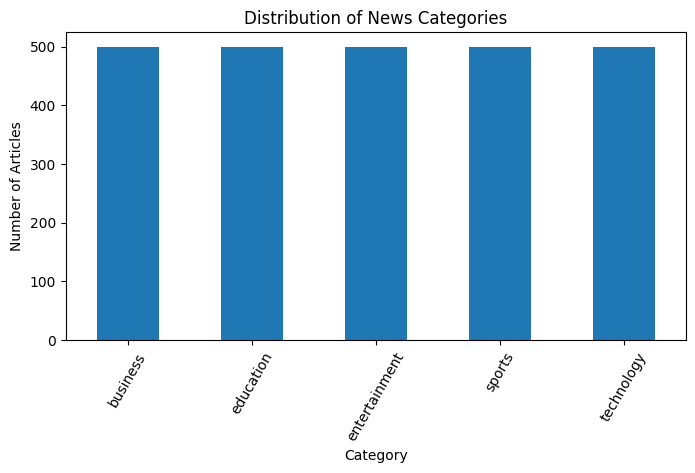

In [19]:
import matplotlib.pyplot as plt
category_counts= new_df["category"].value_counts()
print(category_counts)

category_counts.plot(kind='bar', figsize=(8, 4))
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=60)
plt.show()

Splitting the text into words\tokens and compute the frequency of each word

In [30]:
# Import necessary libraries for text processing
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize and compute word frequencies & limit to top 1000 most frequent words
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df["english_news"])

# Get the word frequencies
word_freq = X.toarray().sum(axis=0)

# Create a DataFrame of word frequencies
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=['Word', 'Frequency'])

# Sort the words by frequency
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Display the top 20 most frequent words
print(word_freq_df.head(20))


         Word  Frequency
431     india        509
22       2023        446
595       new        324
763        rs        317
771      said        296
483      khan        283
23       2024        282
995      year        250
784      says        238
335      film        211
250       day        209
873  students        199
236     crore        193
173      cent        180
432    indian        177
907      test        168
73         ai        166
990     world        163
932        ug        150
612  official        143


Plotting word\token frequencies

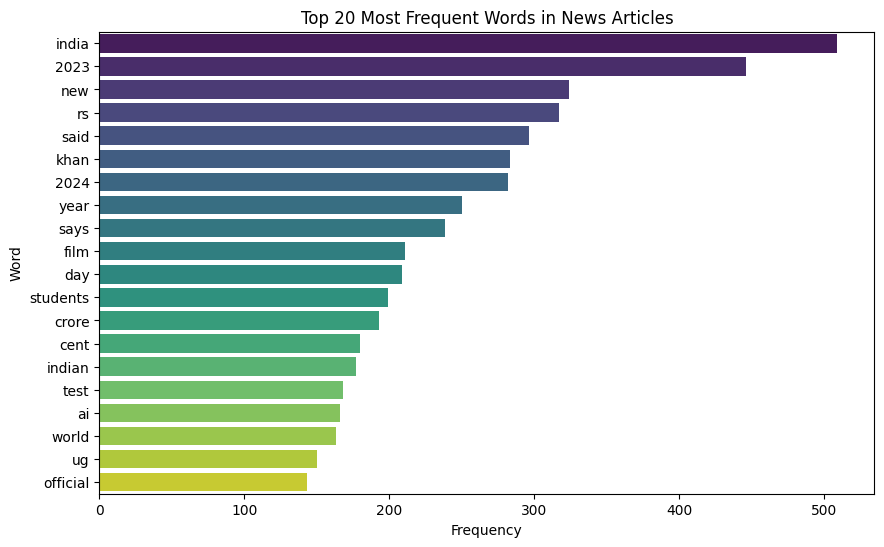

In [59]:
import seaborn as sns

# Visualize the top 20 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(data=word_freq_df.head(20), x='Frequency', y='Word', palette='viridis', hue="Word")
plt.title('Top 20 Most Frequent Words in News Articles')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


Text classification: LSTM model

In [32]:
!pip install tensorflow


In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from sklearn.model_selection import train_test_split

In [41]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['english_news'])

# Convert the text to sequences of integers
X_seq = tokenizer.texts_to_sequences(df['english_news'])
X_pad = pad_sequences(X_seq, padding='post', maxlen=200)

# Encode the target labels (news categories)
label_encoder = LabelEncoder() # Initialize LabelEncoder
label_encoder.fit(df['category'])
y = label_encoder.transform(df['category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=200))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: ", test_acc)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2071 - loss: 1.6113 - val_accuracy: 0.1860 - val_loss: 1.6105
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1823 - loss: 1.6115 - val_accuracy: 0.1760 - val_loss: 1.6116
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2040 - loss: 1.6106 - val_accuracy: 0.1860 - val_loss: 1.6103
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1991 - loss: 1.6097 - val_accuracy: 0.1860 - val_loss: 1.6126
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2080 - loss: 1.6095 - val_accuracy: 0.2000 - val_loss: 1.6091
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1987 - loss: 1.6060
Test Accuracy:  0.20000000298023224


Text classification: Logistic regression

In [43]:
# Import necessary libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Encode the target labels (news categories)
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['encoded_category'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy:  0.924
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       100
           1       0.97      1.00      0.98        88
           2       0.95      0.89      0.92       108
           3       0.91      0.88      0.89       111
           4       0.89      0.91      0.90        93

    accuracy                           0.92       500
   macro avg       0.92      0.93      0.93       500
weighted avg       0.92      0.92      0.92       500



Text classification: CRF

In [91]:
!pip install sklearn-crfsuite
!pip install seqeval

import warnings
warnings.filterwarnings("ignore")


In [76]:
# Import necessary libraries for CRF
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define a function to extract features from a word
def word_features(word):
    return {
        'word': word,
        'is_capitalized': word[0].isupper(),
        'is_numeric': word.isdigit(),
        'length': len(word),
    }

# Apply the feature extraction to all words in a sentence
def sentence_features(sentence):
    return [word_features(word) for word in sentence.split()]

# Prepare the data
X = df['english_news'].apply(sentence_features).tolist()  # Convert text into feature representations

# Convert the news category for each word (sentence) to a list of labels (keep them as strings)
y = df['category'].apply(lambda x: [x] * len(x.split())).tolist()  # Repeat the label for each word in the sentence


# Ensure that X and y have the same number of elements (i.e., number of sentences)
assert len(X) == len(y), "Mismatch between features and labels!"


# Flatten y (because the model needs one label per word across all sentences)
y_flat = [label for sublist in y for label in sublist]

# Flatten X (because each word should have its corresponding feature vector)
X_flat = [word for sentence in X for word in sentence]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, y_train)

# Predict on the test set
y_pred = crf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))



ValueError: The numbers of items and labels differ: |x| = 32, |y| = 1

In [68]:
print(f"Total samples in X: {len(X)}")
print(f"Total samples in y: {len(y)}")

# Check if any sentences have mismatched word-label pairs
for i in range(len(X)):
    if len(X[i]) != len(y[i]):
        print(f"Mismatch found at index {i}: {len(X[i])} words, {len(y[i])} labels")


Total samples in X: 2500
Total samples in y: 2500
Mismatch found at index 0: 39 words, 1 labels
Mismatch found at index 1: 47 words, 1 labels
Mismatch found at index 2: 32 words, 1 labels
Mismatch found at index 3: 38 words, 1 labels
Mismatch found at index 4: 53 words, 1 labels
Mismatch found at index 5: 54 words, 1 labels
Mismatch found at index 6: 36 words, 1 labels
Mismatch found at index 7: 40 words, 1 labels
Mismatch found at index 8: 51 words, 1 labels
Mismatch found at index 9: 34 words, 1 labels
Mismatch found at index 10: 56 words, 1 labels
Mismatch found at index 11: 37 words, 1 labels
Mismatch found at index 12: 45 words, 1 labels
Mismatch found at index 13: 34 words, 1 labels
Mismatch found at index 14: 39 words, 1 labels
Mismatch found at index 15: 48 words, 1 labels
Mismatch found at index 16: 35 words, 1 labels
Mismatch found at index 17: 32 words, 1 labels
Mismatch found at index 18: 33 words, 1 labels
Mismatch found at index 19: 38 words, 1 labels
Mismatch found at in

In [71]:
# Check mismatched samples
for i in range(len(X)):
    if len(X[i]) != len(y[i]):
        print(f"Mismatch at index {i}: {len(X[i])} words vs {len(y[i])} labels")
        print("Text:", df.iloc[i]['english_news'])
        print("Category:", df.iloc[i]['category'])
        print("Tokenized Words:", df.iloc[i]['english_news'].split())
        print("Assigned Labels:", [df.iloc[i]['category']] * len(df.iloc[i]['english_news'].split()))
        print("-" * 50)


Streaming output truncated to the last 5000 lines.
Assigned Labels: ['sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports', 'sports']
--------------------------------------------------
Mismatch at index 1667: 39 words vs 1 labels
Text: Shubman Gill becomes India’s highest individual scorer in T20Is with 126* against New Zealand Gill brought up his century with a four over the mid-off fielder off the bowling of Ferguson in the first ball of the 18th over.
Category: sports
Tokenized Words: ['Shubman', 'Gill', 'becomes', 'India’s', 'highest', 'individual', 'scor

In [75]:
# Ensure labels match word count in each sentence
y = df.apply(lambda row: [row['category']] * len(row['english_news'].split()), axis=1).tolist()

# Ensure no empty values in text column
df['english_news'] = df['english_news'].fillna("").astype(str)  # Convert NaN to empty string

# Now apply the label assignment again
y = df.apply(lambda row: [row['category']] * len(row['english_news'].split()), axis=1).tolist()



In [77]:
print(f"After fix -> Total samples in X: {len(X)}, Total samples in y: {len(y)}")

# Check consistency
assert all(len(X[i]) == len(y[i]) for i in range(len(X))), "Mismatch still exists!"


After fix -> Total samples in X: 2500, Total samples in y: 2500


AssertionError: Mismatch still exists!

In [79]:
# Identify problematic indices where X and y lengths don't match
mismatch_indices = [i for i in range(len(X)) if len(X[i]) != len(y[i])]

print(f"Total mismatches found: {len(mismatch_indices)}")

# Print a few examples
for i in mismatch_indices[:5]:  # Show first 5 mismatches
    print(f"Index {i}: {len(X[i])} words vs {len(y[i])} labels")
    print("Text:", df.iloc[i]['english_news'])
    print("Tokenized Words:", df.iloc[i]['english_news'].split())
    print("Assigned Labels:", y[i])
    print("-" * 50)


Total mismatches found: 2500
Index 0: 39 words vs 1 labels
Text: GST Council: 28% tax on online gaming, casinos and horse-racing The Directorate General of Civil Aviation (DGCA) has put SpiceJet under enhanced surveillance for more than three weeks now and it is an ongoing process, the official told PTI.
Tokenized Words: ['GST', 'Council:', '28%', 'tax', 'on', 'online', 'gaming,', 'casinos', 'and', 'horse-racing', 'The', 'Directorate', 'General', 'of', 'Civil', 'Aviation', '(DGCA)', 'has', 'put', 'SpiceJet', 'under', 'enhanced', 'surveillance', 'for', 'more', 'than', 'three', 'weeks', 'now', 'and', 'it', 'is', 'an', 'ongoing', 'process,', 'the', 'official', 'told', 'PTI.']
Assigned Labels: ['business']
--------------------------------------------------
Index 1: 47 words vs 1 labels
Text: High vegetable prices may push up retail inflation in near term: RBI Governor “The near-term outlook is masked by risks to food inflation which might lead to an inflation uptick in November and Decembe

In [82]:
# Correct: Assign category label for EACH word in the sentence
y = df.apply(lambda row: [row['category']] * len(row['english_news'].split()), axis=1).tolist()


In [83]:
# Check that every sentence has the same number of words and labels
mismatch_indices = [i for i in range(len(X)) if len(X[i]) != len(y[i])]

print(f"Total mismatches found: {len(mismatch_indices)}")
if mismatch_indices:
    for i in mismatch_indices[:5]:  # Show first 5 mismatches
        print(f"Index {i}: {len(X[i])} words vs {len(y[i])} labels")
        print("Text:", df.iloc[i]['english_news'])
        print("Tokenized Words:", X[i])
        print("Assigned Labels:", y[i])
        print("-" * 50)
else:
    print("✅ No mismatches! X and y are correctly aligned.")


Total mismatches found: 0
✅ No mismatches! X and y are correctly aligned.


In [84]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, y_train)

# Predict on the test set
y_pred = crf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [87]:
# Ensure each word in a sentence gets the correct category label
y = df.apply(lambda row: [row['category']] * len(row['english_news'].split()), axis=1).tolist()

# Check for length mismatches
mismatches = [i for i in range(len(X)) if len(X[i]) != len(y[i])]

print(f"Total mismatches found: {len(mismatches)}")
if mismatches:
    for i in mismatches[:5]:  # Show first 5 mismatches
        print(f"Index {i}: {len(X[i])} words vs {len(y[i])} labels")
        print("Text:", df.iloc[i]['english_news'])
        print("Tokenized Words:", X[i])
        print("Assigned Labels:", y[i])
        print("-" * 50)
else:
    print("✅ No mismatches! X and y are correctly aligned.")



Total mismatches found: 0
✅ No mismatches! X and y are correctly aligned.


In [88]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
crf.fit(X_train, y_train)

# Predict on the test set
y_pred = crf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [92]:
from seqeval.metrics import classification_report as seq_classification_report

# Evaluate the model using seqeval (designed for sequence labeling)
print("Classification Report:\n", seq_classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    ducation       0.58      0.77      0.66        88
   echnology       0.67      0.68      0.67        93
ntertainment       0.73      0.64      0.68       108
       ports       0.60      0.52      0.56       111
     usiness       0.68      0.67      0.68       100

   micro avg       0.65      0.65      0.65       500
   macro avg       0.65      0.66      0.65       500
weighted avg       0.66      0.65      0.65       500



Summary:

A. Data Preprocessing & Exploration:

Loaded the dataset and checked for missing values.

Analyzed the distribution of news categories to identify any imbalances.

Tokenized the text and visualized word frequency to understand important features.

B. Statistical Machine Learning (SML) vs. Deep Learning (DL):

I chose Statistical Machine Learning (SML) over Deep Learning (DL) because the dataset was not very large, and SML models like Logistic Regression are easier to train and more effective for smaller datasets. Additionally, SML models are computationally less expensive compared to deep learning models.

C. Logistic Regression vs. CRF:

I preferred Logistic Regression over CRF because I encountered many errors while trying to implement CRF, making it more challenging to set up. Logistic Regression is simpler and works well for text classification tasks where the relationship between features and labels is relatively straightforward.

D. GRU is simpler and faster to train, while still capturing long-term dependencies in the data, making it a more efficient choice compared to LSTM.

In [2]:
!git config --global user.name AsisiphoMB22
!git config --global user.email "asisiphombobo40@gmail.com"

In [4]:
!git clone https://github.com/Sthembiso-Mkhwanazi/news_classification.git


Cloning into 'news_classification'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 484.52 KiB | 5.84 MiB/s, done.


In [5]:
cd news_classification


/content/news_classification
